https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent

Nessa base temos características de imóveis e o valor total a ser gasto mensalmente. Tentarei prever qual o rent amount de acordo com os outras características.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import dabl

import re

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('houses_to_rent.csv')

In [3]:
df.head()

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,0,1,240,3,3,4,-,acept,furnished,R$0,"R$8,000","R$1,000",R$121,"R$9,121"
1,1,0,64,2,1,1,10,acept,not furnished,R$540,R$820,R$122,R$11,"R$1,493"
2,2,1,443,5,5,4,3,acept,furnished,"R$4,172","R$7,000","R$1,417",R$89,"R$12,680"
3,3,1,73,2,2,1,12,acept,not furnished,R$700,"R$1,250",R$150,R$16,"R$2,116"
4,4,1,19,1,1,0,-,not acept,not furnished,R$0,"R$1,200",R$41,R$16,"R$1,257"


## Adequação dos dados

#print(*df.hoa.unique(), sep='\n')

#print(*df['property tax'].unique(), sep='\n')

Temos nas colunas hoe e property tax os valores: Incluso e Sem info. Vamos substituí-los por zero

In [4]:
df['hoa'] = df['hoa'].replace('Sem info','0')
df['hoa'] = df['hoa'].replace('Incluso','0')

In [5]:
df['property tax'] = df['property tax'].replace('Sem info','0')
df['property tax'] = df['property tax'].replace('Incluso','0')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 14 columns):
Unnamed: 0        6080 non-null int64
city              6080 non-null int64
area              6080 non-null int64
rooms             6080 non-null int64
bathroom          6080 non-null int64
parking spaces    6080 non-null int64
floor             6080 non-null object
animal            6080 non-null object
furniture         6080 non-null object
hoa               6080 non-null object
rent amount       6080 non-null object
property tax      6080 non-null object
fire insurance    6080 non-null object
total             6080 non-null object
dtypes: int64(6), object(8)
memory usage: 665.1+ KB


Precisamos remover os símbolos R$ 

In [7]:
df.total = df['total'].map(lambda x: re.sub('\D', '', x))
df.hoa = df.hoa.map(lambda x: re.sub('\D', '', x))
df['rent amount'] = df['rent amount'].map(lambda x: re.sub('\D', '', x))
df['property tax'] = df['property tax'].map(lambda x: re.sub('\D', '', x))
df['fire insurance'] = df['fire insurance'].map(lambda x: re.sub('\D', '', x))

# [.map()] Used for substituting each value in a Series with another value
# [\D] Matches any character which is not a decimal digit.

df.head(1)

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,0,1,240,3,3,4,-,acept,furnished,0,8000,1000,121,9121


In [8]:
df.isnull().sum()

Unnamed: 0        0
city              0
area              0
rooms             0
bathroom          0
parking spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent amount       0
property tax      0
fire insurance    0
total             0
dtype: int64

Transformar o tipo de object para float

In [9]:
df.total = pd.to_numeric(df.total).astype(float)
df.hoa = pd.to_numeric(df.hoa).astype(float)
df['rent amount'] = pd.to_numeric(df['rent amount']).astype(float)
df['property tax'] = pd.to_numeric(df['property tax']).astype(float)
df['fire insurance'] = pd.to_numeric(df['fire insurance']).astype(float)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 14 columns):
Unnamed: 0        6080 non-null int64
city              6080 non-null int64
area              6080 non-null int64
rooms             6080 non-null int64
bathroom          6080 non-null int64
parking spaces    6080 non-null int64
floor             6080 non-null object
animal            6080 non-null object
furniture         6080 non-null object
hoa               6080 non-null float64
rent amount       6080 non-null float64
property tax      6080 non-null float64
fire insurance    6080 non-null float64
total             6080 non-null float64
dtypes: float64(5), int64(6), object(3)
memory usage: 665.1+ KB


# Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x2110eaf9dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x2110eb124a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2110eaf9978>],
 'medians': [<matplotlib.lines.Line2D at 0x2110eb12b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x2110eb12e80>],
 'means': []}

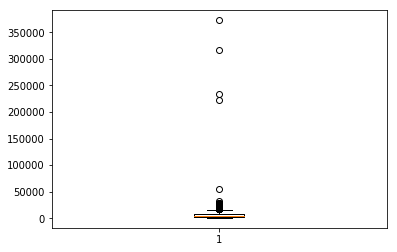

In [11]:
plt.boxplot(df.total)

In [12]:
df[df.total > 50000]

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
1269,1269,1,340,5,4,2,7,acept,not furnished,220000.0,12000.0,1000.0,153.0,233200.0
2611,2611,1,42,1,2,1,6,not acept,not furnished,690.0,2500.0,313700.0,32.0,316900.0
3303,3303,1,285,4,5,4,6,acept,furnished,200000.0,20000.0,1834.0,254.0,222100.0
3381,3381,1,700,4,7,8,-,acept,not furnished,0.0,45000.0,8750.0,677.0,54430.0
5627,5627,1,93,3,3,0,16,not acept,furnished,1221.0,5100.0,366300.0,65.0,372700.0


* O 1269 tem um valor absurdo de condomínio, 220000,00. O 3303 tem condomínio de 200000. Não deve estar correto
* O 2611 tem o valor de IPUT de 313700,00 com 42 metros quadrados. 
* O 5627 tem IPUT de 366300,00
* O único com valor plausível é o 3381. 

In [13]:
df = df.drop([1269, 3303, 2611, 5627])

## Análise exploratória

In [14]:
df.drop(columns=['total'], inplace=True)

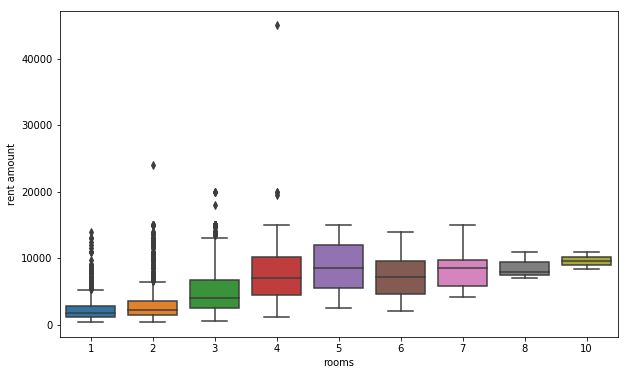

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x='rooms', y='rent amount', data=df)

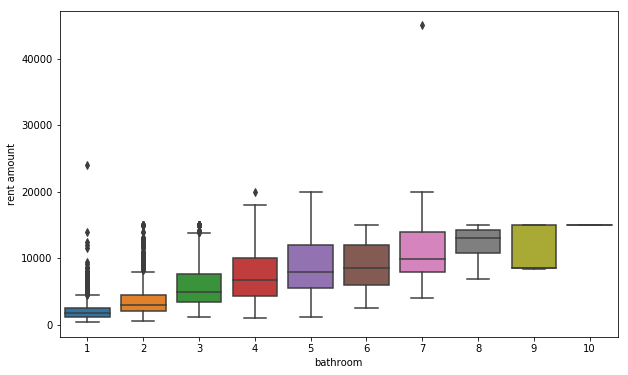

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x='bathroom', y='rent amount', data=df)

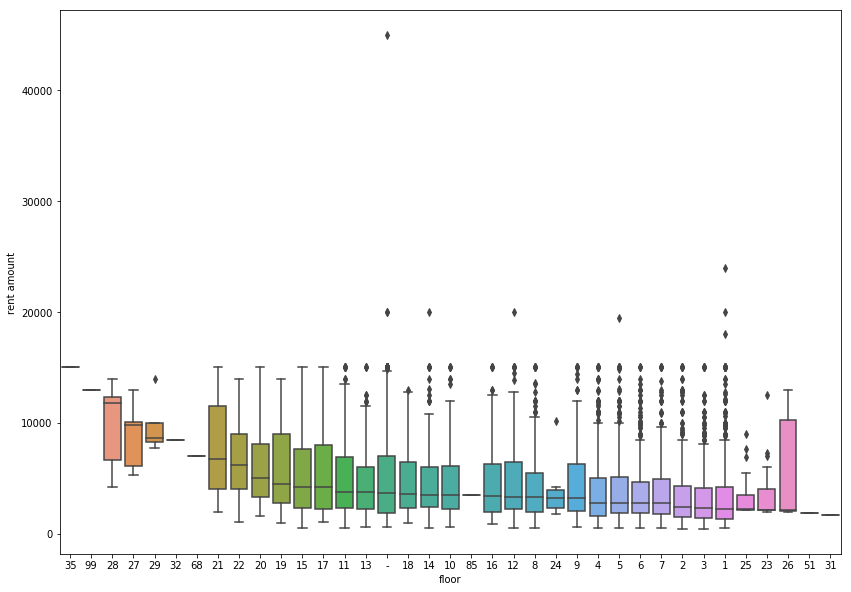

In [17]:
plt.figure(figsize=(14,10))
minha_ordem = df.groupby('floor')['rent amount'].median().sort_values().iloc[::-1].index
sns.boxplot(x='floor', y='rent amount', data=df, order=minha_ordem)

Andares mais altos tem em geral custos maiores. 
O traço, que representa casas, está entre os valores maiores de 10. Vou substituí- lo por 10.

In [18]:
df.floor = df.floor.map(lambda x: re.sub('-', '10', x))
df.floor = pd.to_numeric(df.floor).astype(float)

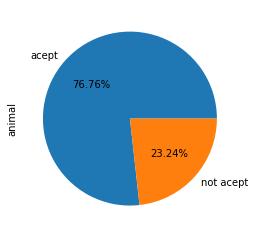

In [19]:
df['animal'].value_counts().plot(kind='pie', autopct = '%.2f%%')

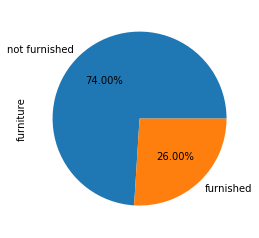

In [20]:
df['furniture'].value_counts().plot(kind='pie', autopct = '%.2f%%')

               rent amount
furniture                 
furnished      5378.025316
not furnished  4045.786032


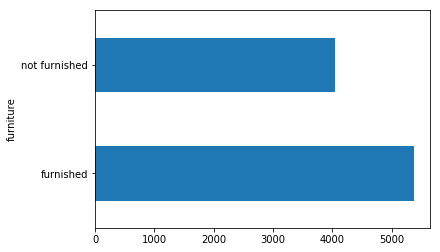

In [21]:
print(pd.DataFrame(df.groupby('furniture')['rent amount'].mean()))
df.groupby('furniture')['rent amount'].mean().plot(kind='barh')

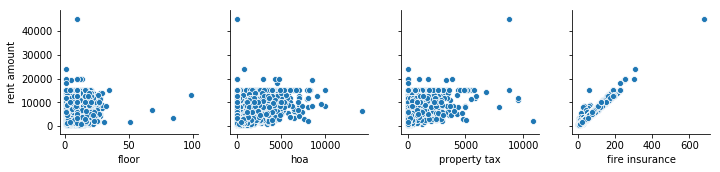

In [22]:
sns.pairplot(df, y_vars=['rent amount'], x_vars=['floor', 'hoa','property tax', 'fire insurance'])

O rent amount tem um relação forte com o fire insurance

Target looks like regression


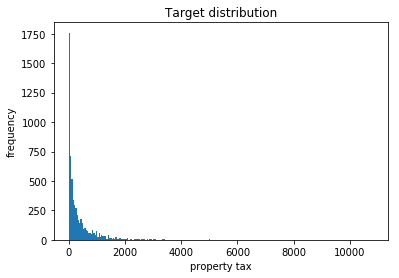

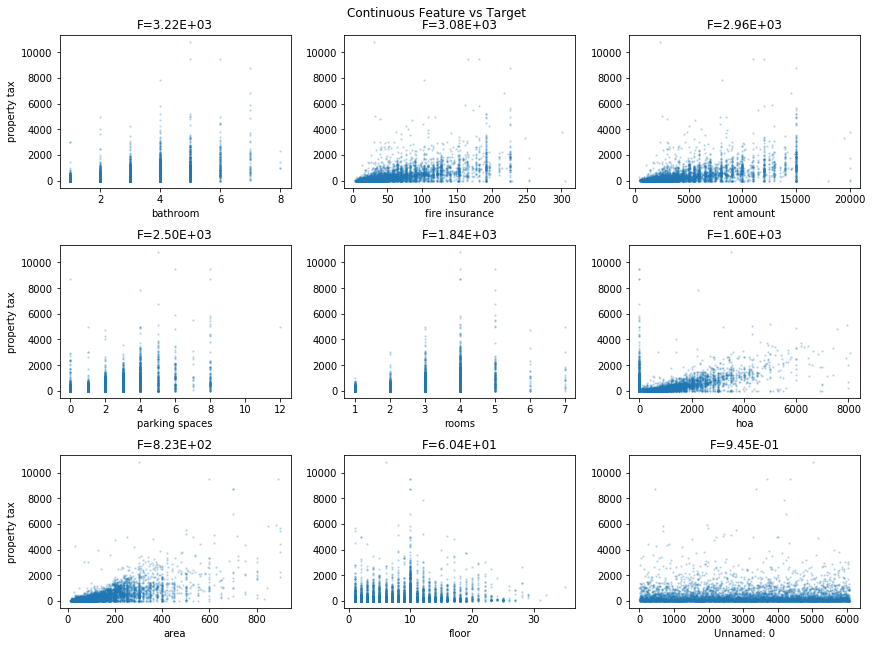

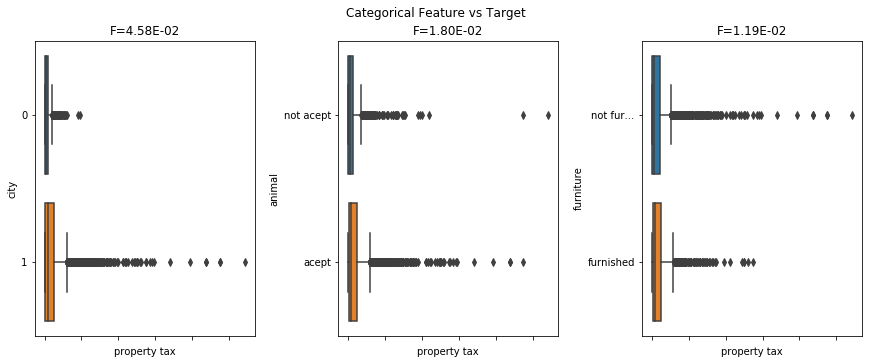

In [23]:
dabl.plot(df, 'property tax')

In [24]:
df_s = pd.DataFrame(preprocessing.scale(df[['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'hoa', 'rent amount',
                             'property tax', 'fire insurance']]))

In [25]:
df[['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'hoa', 'rent amount', 'property tax', 'fire insurance']] = df_s

In [26]:
df.isna().sum()

Unnamed: 0        0
city              0
area              4
rooms             4
bathroom          4
parking spaces    4
floor             4
animal            0
furniture         0
hoa               4
rent amount       4
property tax      4
fire insurance    4
dtype: int64

In [27]:
df[df.isna().any(axis=1)]

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance
6076,6076,1,NaN,NaN,NaN,NaN,NaN,not acept,furnished,NaN,NaN,NaN,NaN
6077,6077,0,NaN,NaN,NaN,NaN,NaN,acept,not furnished,NaN,NaN,NaN,NaN
6078,6078,1,NaN,NaN,NaN,NaN,NaN,not acept,not furnished,NaN,NaN,NaN,NaN
6079,6079,1,NaN,NaN,NaN,NaN,NaN,acept,furnished,NaN,NaN,NaN,NaN


As últimas quatro linhas são as que contem Nan

In [28]:
df.drop(index=[6076, 6077, 6078, 6079],inplace=True)

In [29]:
df.drop(columns=['Unnamed: 0'], inplace=True)
# Essa coluna não nos diz nada

## Seleção de variáveis

In [30]:
df = pd.get_dummies(df, columns=['animal', 'furniture'], drop_first=True)

In [31]:
df.shape

(6072, 12)

In [32]:
X = df.drop(columns=['rent amount'])
y = df['rent amount']

In [33]:
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent amount   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 2.914e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:                 3488.0
No. Observations:                6072   AIC:                            -6954.
Df Residuals:                    6061   BIC:                            -6880.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
city                      

O P-valor de animal acept é maior que 0,05 tem o maior valor. É o primeiro a ser retirado

In [34]:
X = X.drop(columns=['animal_not acept'])
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent amount   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 3.206e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:                 3488.0
No. Observations:                6072   AIC:                            -6956.
Df Residuals:                    6062   BIC:                            -6889.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
city                      

O P-valor de area é maior que 0,05 tem o maior valor

In [35]:
X = X.drop(columns=['area'])
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent amount   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 3.563e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:                 3487.9
No. Observations:                6072   AIC:                            -6958.
Df Residuals:                    6063   BIC:                            -6897.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
city                      

O P-valor de bathroom é maior que 0,05 tem o maior valor

In [36]:
X = X.drop(columns=['bathroom'])
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent amount   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 4.008e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:                 3487.5
No. Observations:                6072   AIC:                            -6959.
Df Residuals:                    6064   BIC:                            -6905.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
city                      

O P-valor de city é maior que 0,05 tem o maior valor

In [37]:
X = X.drop(columns=['city'])
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent amount   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 4.579e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:                 3486.1
No. Observations:                6072   AIC:                            -6958.
Df Residuals:                    6065   BIC:                            -6911.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
rooms                     

O P-valor de furniture_not furnished é maior que 0,05 tem o maior valor

In [38]:
X = X.drop(columns=['furniture_not furnished'])
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            rent amount   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 5.343e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:                 3485.9
No. Observations:                6072   AIC:                            -6960.
Df Residuals:                    6066   BIC:                            -6920.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
rooms             -0.0245      0.002    -10.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34)

## Modelagem e avaliação

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
predictions = model.predict(X_test)

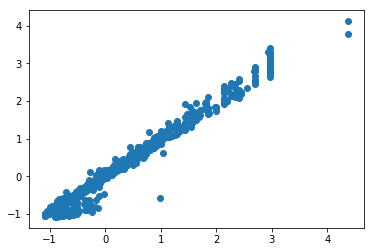

In [42]:
plt.scatter(y_test,predictions)

In [43]:
score = r2_score(y_test, predictions)
print(score)

0.9848386927181256


O valor máximo positivo do r2 é 1. Quanto mais próximo de 1 melhor

In [44]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.07580645003841713
MSE: 0.01513858363840167
RMSE: 0.12303895171205609


In [45]:
model.coef_

array([-0.02414767, -0.01468383,  0.00293961,  0.10666623, -0.02808884,
        0.98476356])

In [46]:
coef = pd.DataFrame(model.coef_, X.columns, columns=['Coefs'])
coef

,Coefs
rooms,-0.024148
parking spaces,-0.014684
floor,0.002940
hoa,0.106666
property tax,-0.028089
fire insurance,0.984764


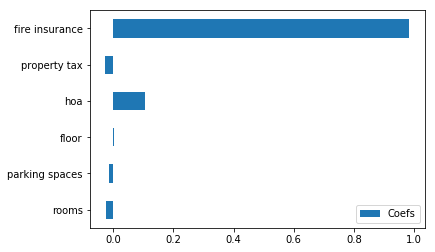

In [47]:
coef.plot(kind='barh')